In [12]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [13]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../Dữ liệu Lịch sử GVR.csv')
df['Ngày']=pd.to_datetime(df.Ngày, format ="%d/%m/%Y")
  # Sort the dataframe by date in ascending order
df = df.sort_values('Ngày')
new_column_names = {'Ngày': 'Date', 'Lần cuối': 'Close', 'Mở': 'Open', 'Cao': 'High', 'Thấp': 'Low', '% Thay đổi': 'Volume'}
df.rename(columns=new_column_names, inplace=True)

from datetime import datetime, date 

df['Close'] = df['Close'].astype(str).apply(lambda x: float(x.replace(',', '')))
df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)

df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

df1=df.reset_index()['Close']

In [14]:
df1

0       10736.0
1       10342.0
2       10145.0
3       10736.0
4       11327.0
         ...   
1265    15300.0
1266    15100.0
1267    15350.0
1268    15450.0
1269    15550.0
Name: Close, Length: 1270, dtype: float64

In [15]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [17]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [20]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 3s 93ms/step - loss: 0.0224 - val_loss: 0.0330
Epoch 2/100
11/11 [==============================] - 1s 49ms/step - loss: 0.0093 - val_loss: 0.0432
Epoch 3/100
11/11 [==============================] - 1s 59ms/step - loss: 0.0034 - val_loss: 0.0122
Epoch 4/100
11/11 [==============================] - 1s 53ms/step - loss: 9.8143e-04 - val_loss: 0.0051
Epoch 5/100
11/11 [==============================] - 1s 48ms/step - loss: 7.6181e-04 - val_loss: 0.0019
Epoch 6/100
11/11 [==============================] - 1s 49ms/step - loss: 5.8971e-04 - val_loss: 0.0024
Epoch 7/100
11/11 [==============================] - 1s 48ms/step - loss: 5.4058e-04 - val_loss: 0.0013
Epoch 8/100
11/11 [==============================] - 1s 47ms/step - loss: 5.3785e-04 - val_loss: 0.0015
Epoch 9/100
11/11 [==============================] - 1s 47ms/step - loss: 5.1182e-04 - val_loss: 0.0013
Epoch 10/100
11/11 [==============================] - 1s 53ms/step - loss: 5

In [22]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 11ms/step


In [23]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [24]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 15604.17876471777
Testing RMSE: 35304.68992362198


In [26]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=193
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.47041628 0.45050865 0.44907624 0.45904467 0.48324953 0.48181712
 0.50458957 0.50742516 0.50458957 0.50175398 0.50602198 0.51599041
 0.52025842 0.514558   0.50458957 0.50885758 0.50885758 0.50742516
 0.50032156 0.49462114 0.49035313 0.47468428 0.48324953 0.48892072
 0.52595884 0.52452643 0.5117224  0.5601029  0.55156688 0.54729888
 0.53876286 0.53589804 0.51312558 0.52309401 0.51312558 0.514558
 0.51312558 0.52736202 0.50175398 0.45334425 0.47041628 0.46331268
 0.4732811  0.46614827 0.45617984 0.44907624 0.43340739 0.3963985
 0.3963985  0.35512161 0.32094832 0.34515318 0.30814429 0.273971
 0.28250702 0.24976614 0.26759822 0.26905987 0.28221469 0.28659963
 0.29244621 0.28513798 0.27490645 0.24275023 0.21205566 0.19013096
 0.19597755 0.22228718 0.22521048 0.22228718 0.22521048 0.2164406
 0.21790225 0.19159261 0.16528297 0.18282273 0.19013096 0.16382133
 0.13897334 0.115587   0.0936623  0.11412535 0.1345884  0.1565131
 0.18136109 0.16966791 0.16820627 0.18136109 0.19597755 0

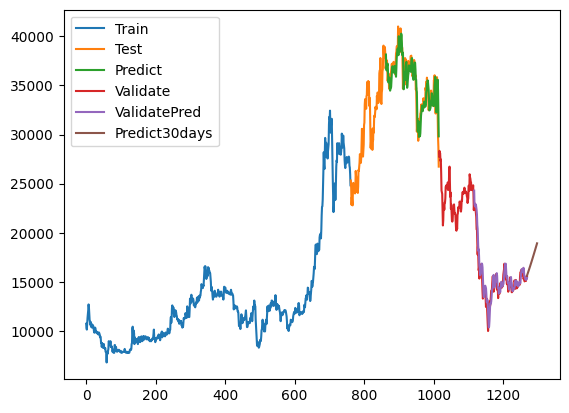

In [27]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()